In [354]:
# Importando librerias necesarias
import cv2 as cv
import numpy as np

from matplotlib import pyplot as plt
from skimage.morphology import skeletonize
from skimage.measure import approximate_polygon

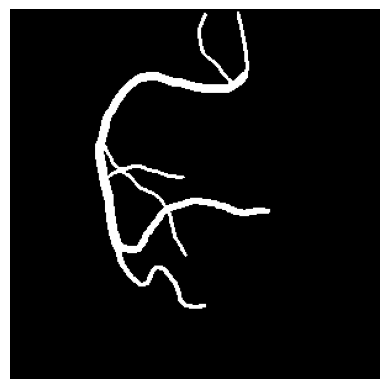

In [355]:
image_path = 'images/1_gt.pgm'
imagen_color = cv.imread(image_path)
imagen_gris = cv.cvtColor(imagen_color, cv.COLOR_BGR2GRAY)
_, binary_image = cv.threshold(imagen_gris, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

plt.imshow(binary_image, cmap='gray')
plt.axis('off')
plt.show()

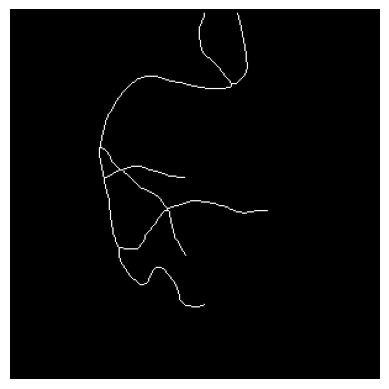

In [356]:
skeleton = skeletonize(binary_image)
plt.imshow(skeleton, cmap='gray')
plt.axis('off')
plt.show()

In [357]:
all_nodes_list = []
for i in range(1, skeleton.shape[0] - 1):
    for j in range(1, skeleton.shape[1] - 1):
        if skeleton[i, j]: all_nodes_list.append((i, j))

all_nodes_list = np.array(all_nodes_list)

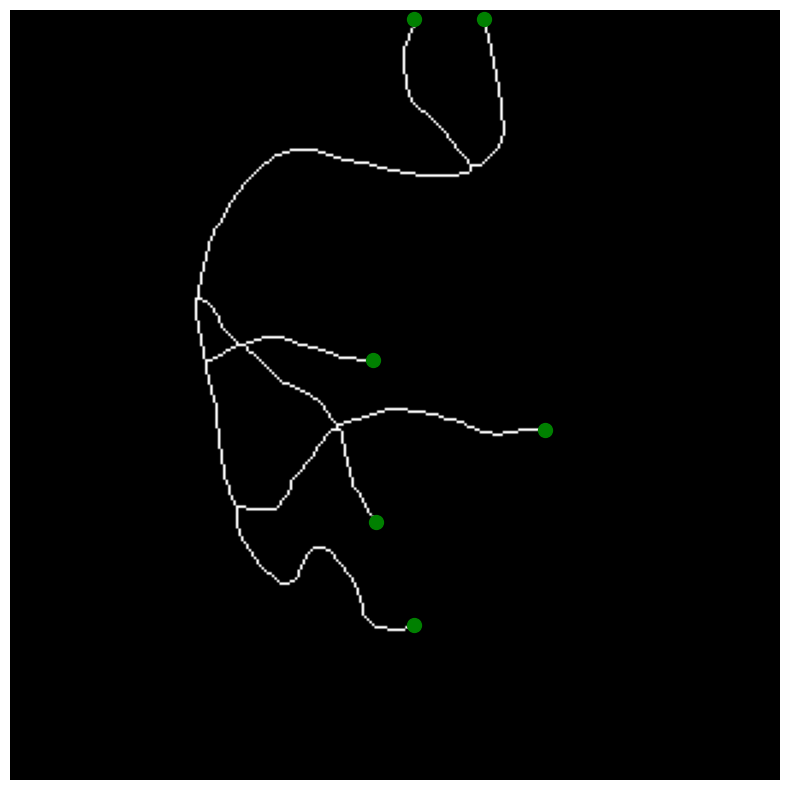

In [358]:
extreme_nodes_list = []
for i in range(1, skeleton.shape[0] - 1):
    for j in range(1, skeleton.shape[1] - 1):
        if skeleton[i, j]:
            rows, columns = np.ogrid[i-1:i+2, j-1:j+2]
            if np.sum(skeleton[rows, columns]) == 2:
                extreme_nodes_list.append((i, j))


plt.figure(figsize=(10,10))
plt.imshow(skeleton, cmap='gray')
plt.plot([node[1] for node in extreme_nodes_list], 
         [node[0] for node in extreme_nodes_list], 
         'go',
          markersize=10)

plt.axis('off')
plt.show()

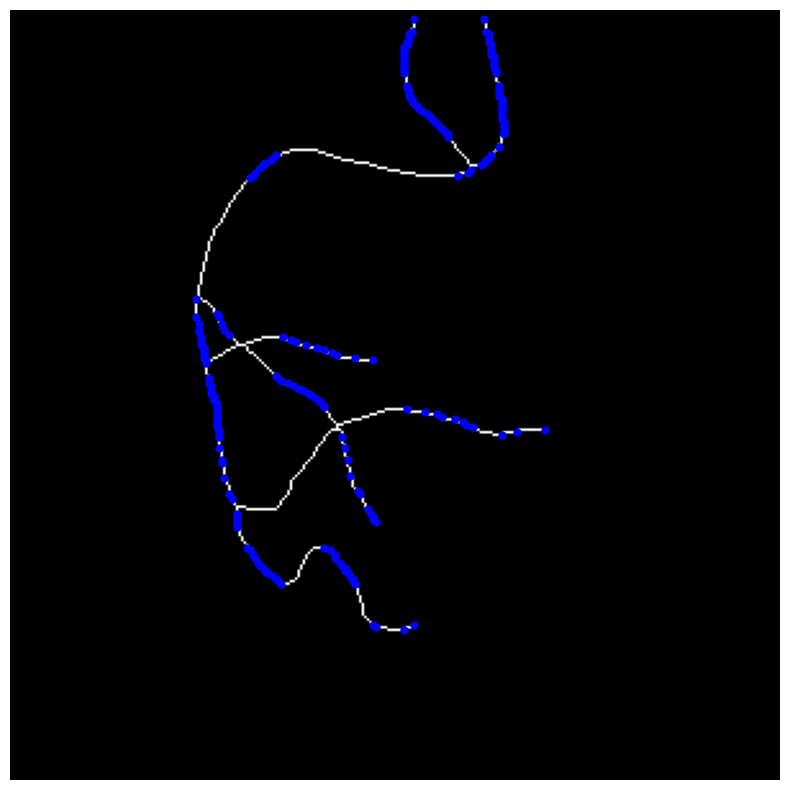

In [359]:
tolerance = 5
ap = approximate_polygon(all_nodes_list, tolerance)

plt.figure(figsize=(10,10))
plt.imshow(skeleton, cmap='gray')
plt.plot([node[1] for node in ap], 
         [node[0] for node in ap], 
         'o',
         color='blue',
         markersize=5)
plt.axis('off')
plt.show()

In [360]:
print(ap[0])

[  3 157]


In [361]:
# Bifurcaciones y Trifurcaciones

# Bifurcation - Nodo con 3 vecinos
# Trifurcation - Nodo con 4 vecinos

bifurcation_nodes_list = []
trifurcation_nodes_list = []

for i in range(1, skeleton.shape[0] - 1):
		for j in range(1, skeleton.shape[1] - 1):
				if skeleton[i, j]:
						# Check if is not already in either list
						right = skeleton[i, j+1] and (i, j+1) not in bifurcation_nodes_list and (i, j+1) not in trifurcation_nodes_list
						left = skeleton[i, j-1] and (i, j-1) not in bifurcation_nodes_list and (i, j-1) not in trifurcation_nodes_list
						up = skeleton[i-1, j] and (i-1, j) not in bifurcation_nodes_list and (i-1, j) not in trifurcation_nodes_list
						down = skeleton[i+1, j] and (i+1, j) not in bifurcation_nodes_list and (i+1, j) not in trifurcation_nodes_list
						upper_left = skeleton[i-1, j-1] and (i-1, j-1) not in bifurcation_nodes_list and (i-1, j-1) not in trifurcation_nodes_list
						upper_right = skeleton[i-1, j+1] and (i-1, j+1) not in bifurcation_nodes_list and (i-1, j+1) not in trifurcation_nodes_list
						lower_left = skeleton[i+1, j-1] and (i+1, j-1) not in bifurcation_nodes_list and (i+1, j-1) not in trifurcation_nodes_list
						lower_right = skeleton[i+1, j+1] and (i+1, j+1) not in bifurcation_nodes_list and (i+1, j+1) not in trifurcation_nodes_list
						neighbors = [right, left, up, down, upper_left, upper_right, lower_left, lower_right]
						neighbors_sum = np.sum(neighbors)
						# Trifurcation has higher priority
						if neighbors_sum == 4:
								trifurcation_nodes_list.append((i, j))
						elif neighbors_sum == 3:
								bifurcation_nodes_list.append((i, j))
						


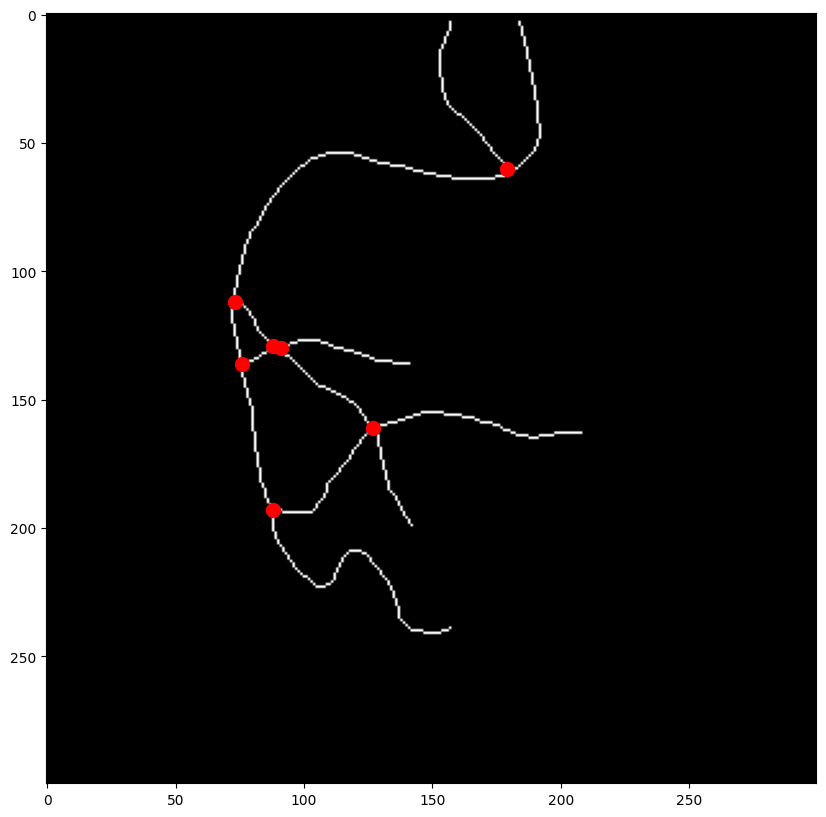

In [362]:
# Plot bifurcation in green

plt.figure(figsize=(10,10))
plt.imshow(skeleton, cmap='gray')
plt.plot([node[1] for node in bifurcation_nodes_list], 
				 [node[0] for node in bifurcation_nodes_list], 
				 'ro',
					markersize=10)

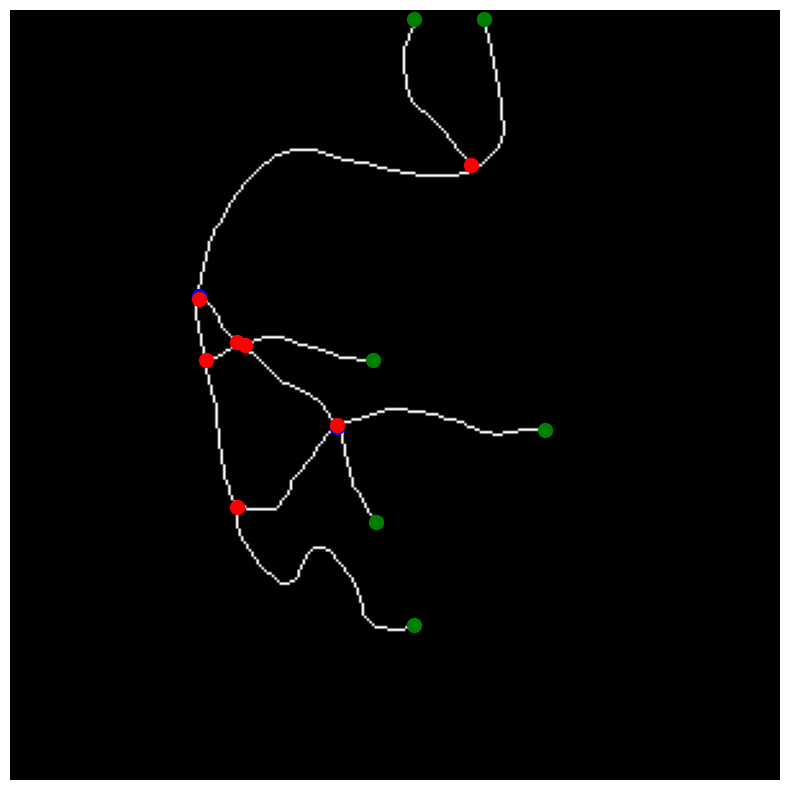

In [363]:
# Plot bifurcation in red
# Plot trifurcation in blue
plt.figure(figsize=(10,10))
plt.imshow(skeleton, cmap='gray')
plt.plot([node[1] for node in trifurcation_nodes_list], 
				 [node[0] for node in trifurcation_nodes_list], 
				 'bo',
					markersize=10)
plt.plot([node[1] for node in bifurcation_nodes_list], 
				 [node[0] for node in bifurcation_nodes_list], 
				 'ro',
					markersize=10)

plt.plot([node[1] for node in extreme_nodes_list], 
         [node[0] for node in extreme_nodes_list], 
         'go',
          markersize=10)

plt.axis('off')
plt.show()

(-0.5, 299.5, 299.5, -0.5)

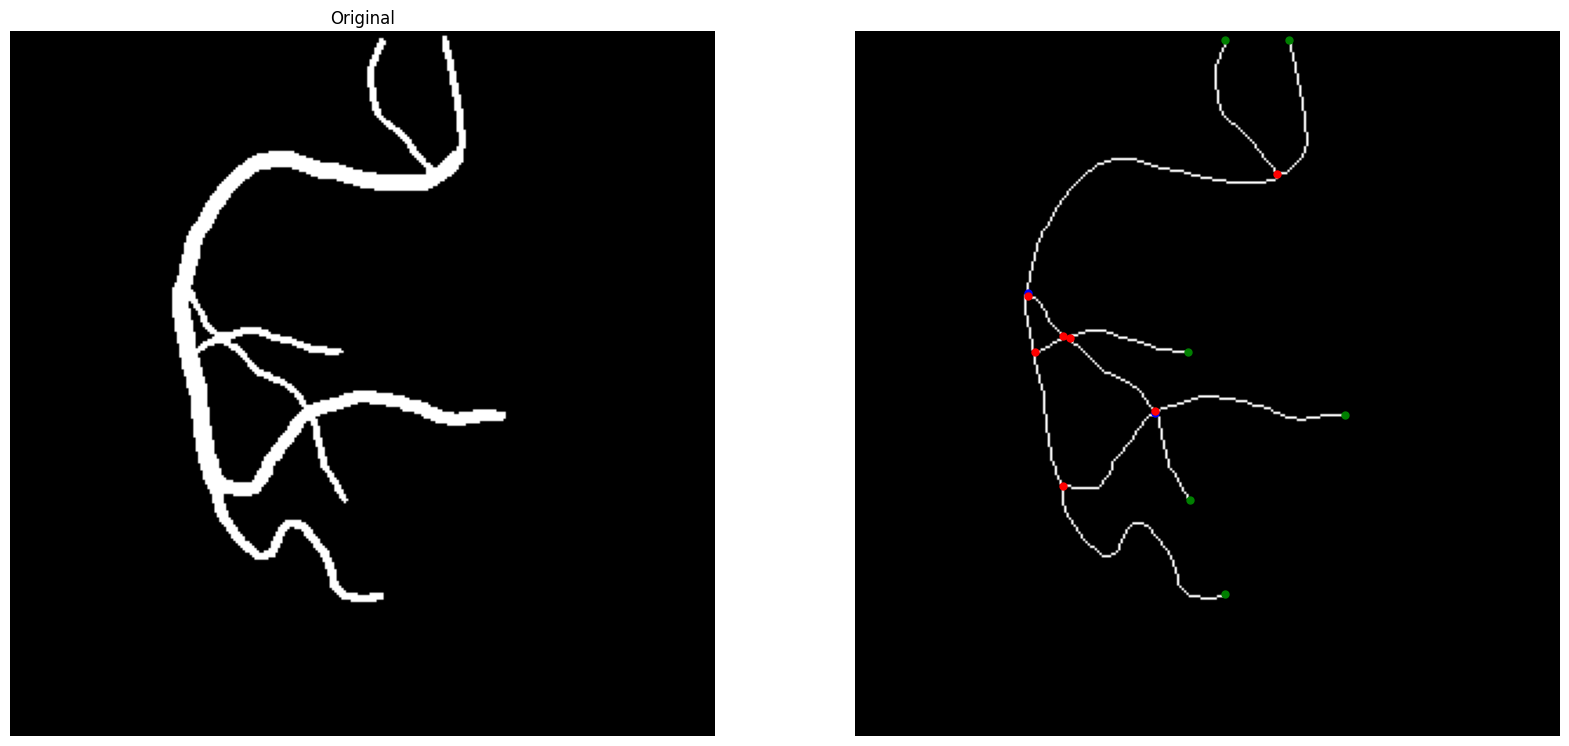

In [364]:
# Plot original image and the resulting side by side
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(imagen_color)
plt.axis('off')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(skeleton, cmap='gray')
plt.plot([node[1] for node in trifurcation_nodes_list], 
				 [node[0] for node in trifurcation_nodes_list], 
				 'bo',
					markersize=5)
plt.plot([node[1] for node in bifurcation_nodes_list], 
				 [node[0] for node in bifurcation_nodes_list], 
				 'ro',
					markersize=5)

plt.plot([node[1] for node in extreme_nodes_list], 
         [node[0] for node in extreme_nodes_list], 
         'go',
          markersize=5)

plt.axis('off')



In [365]:
# Returns skeleton, bifurcation_nodes_list, trifurcation_nodes_list, extreme_nodes_list, ap
def get_image_features(image_path):
		imagen_color = cv.imread(image_path)
		imagen_gris = cv.cvtColor(imagen_color, cv.COLOR_BGR2GRAY)
		_, binary_image = cv.threshold(imagen_gris, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
		skeleton = skeletonize(binary_image)
		all_nodes_list = []
		for i in range(1, skeleton.shape[0] - 1):
				for j in range(1, skeleton.shape[1] - 1):
						if skeleton[i, j]: all_nodes_list.append((i, j))

		all_nodes_list = np.array(all_nodes_list)
		extreme_nodes_list = []
		for i in range(1, skeleton.shape[0] - 1):
				for j in range(1, skeleton.shape[1] - 1):
						if skeleton[i, j]:
								rows, columns = np.ogrid[i-1:i+2, j-1:j+2]
								if np.sum(skeleton[rows, columns]) == 2:
										extreme_nodes_list.append((i, j))

		tolerance = 4
		ap = approximate_polygon(all_nodes_list, tolerance)

		bifurcation_nodes_list = []
		trifurcation_nodes_list = []

		for i in range(1, skeleton.shape[0] - 1):
				for j in range(1, skeleton.shape[1] - 1):
						if skeleton[i, j]:
								right = skeleton[i, j+1] and (i, j+1) not in bifurcation_nodes_list and (i, j+1) not in trifurcation_nodes_list
								left = skeleton[i, j-1] and (i, j-1) not in bifurcation_nodes_list and (i, j-1) not in trifurcation_nodes_list
								up = skeleton[i-1, j] and (i-1, j) not in bifurcation_nodes_list and (i-1, j) not in trifurcation_nodes_list
								down = skeleton[i+1, j] and (i+1, j) not in bifurcation_nodes_list and (i+1, j) not in trifurcation_nodes_list
								upper_left = skeleton[i-1, j-1] and (i-1, j-1) not in bifurcation_nodes_list and (i-1, j-1) not in trifurcation_nodes_list
								upper_right = skeleton[i-1, j+1] and (i-1, j+1) not in bifurcation_nodes_list and (i-1, j+1) not in trifurcation_nodes_list
								lower_left = skeleton[i+1, j-1] and (i+1, j-1) not in bifurcation_nodes_list and (i+1, j-1) not in trifurcation_nodes_list
								lower_right = skeleton[i+1, j+1] and (i+1, j+1) not in bifurcation_nodes_list and (i+1, j+1) not in trifurcation_nodes_list
								neighbors = [right, left, up, down, upper_left, upper_right, lower_left, lower_right]
								neighbors_sum = np.sum(neighbors)
								if neighbors_sum == 4:
										trifurcation_nodes_list.append((i, j))
										trifurcation_nodes_list.append((i + 1, j))
										trifurcation_nodes_list.append((i - 1, j))
										trifurcation_nodes_list.append((i, j + 1))
										trifurcation_nodes_list.append((i, j - 1))
										trifurcation_nodes_list.append((i + 1, j + 1))
										trifurcation_nodes_list.append((i - 1, j - 1))
										trifurcation_nodes_list.append((i + 1, j - 1))
										trifurcation_nodes_list.append((i - 1, j + 1))
								elif neighbors_sum == 3:
										bifurcation_nodes_list.append((i, j))
										bifurcation_nodes_list.append((i + 1, j))
										bifurcation_nodes_list.append((i - 1, j))
										bifurcation_nodes_list.append((i, j + 1))
										bifurcation_nodes_list.append((i, j - 1))
										bifurcation_nodes_list.append((i + 1, j + 1))
										bifurcation_nodes_list.append((i - 1, j - 1))
										bifurcation_nodes_list.append((i + 1, j - 1))
										bifurcation_nodes_list.append((i - 1, j + 1))
										
		return skeleton, bifurcation_nodes_list, trifurcation_nodes_list, extreme_nodes_list, ap									

In [366]:
def plot(image_path):
		original_image = cv.imread(image_path)
		skeleton, bifurcation_nodes_list, trifurcation_nodes_list, extreme_nodes_list, ap = get_image_features(image_path)
		plt.figure(figsize=(20,20))
		plt.subplot(1, 2, 1)
		plt.imshow(original_image)
		plt.axis('off')
		plt.title('Original')
		plt.subplot(1, 2, 2)
		plt.imshow(skeleton, cmap='gray')
		plt.plot([node[1] for node in trifurcation_nodes_list], 
						 [node[0] for node in trifurcation_nodes_list], 
						 'bo',
							markersize=5)
		plt.plot([node[1] for node in bifurcation_nodes_list], 
						 [node[0] for node in bifurcation_nodes_list], 
						 'ro',
							markersize=5)

		plt.plot([node[1] for node in extreme_nodes_list], 
					 [node[0] for node in extreme_nodes_list], 
					 'go',
						markersize=5)

		plt.axis('off')
		plt.show()

In [367]:
skeleton, bifurcation_nodes_list, trifurcation_nodes_list, extreme_nodes_list, ap = get_image_features('images/10_gt.pgm')

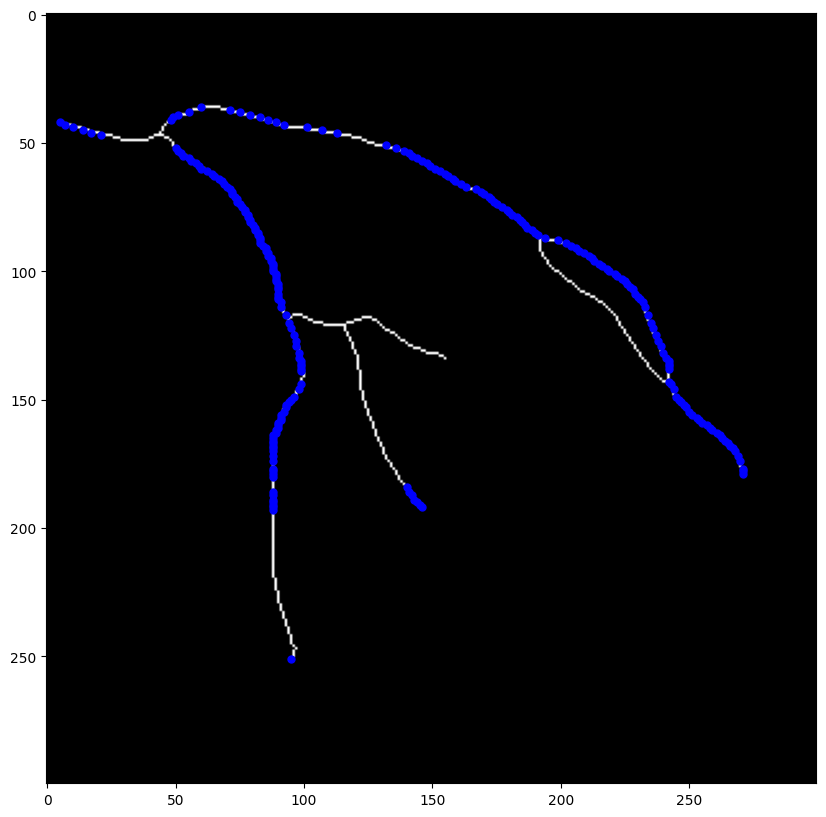

In [368]:
# Plot skeleton
plt.figure(figsize=(10,10))
plt.imshow(skeleton, cmap='gray')
# Plot ap
plt.plot([node[1] for node in ap], 
				 [node[0] for node in ap], 
				 'o',
				 color='blue',
				 markersize=5)
plt.show()


# PathFinding

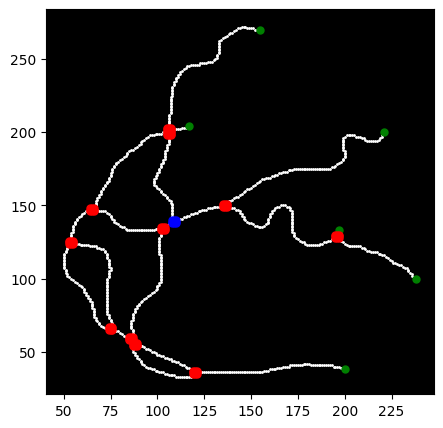

In [369]:
skeleton, bifurcation_nodes_list, trifurcation_nodes_list, extreme_nodes_list, ap = get_image_features('images/11_gt.pgm')

# Convert skeleton to x,y coordinates
skeleton_coords = np.argwhere(skeleton == 1)
# Plot skeleton_coords
plt.figure(figsize=(5,5))
plt.plot(skeleton_coords[:, 1], skeleton_coords[:, 0], 'wo', markersize=1)
# Plot extreme nodes
plt.plot([node[1] for node in extreme_nodes_list], 
				 [node[0] for node in extreme_nodes_list], 
				 'go',
					markersize=5)
plt.axis('on')
# Plot bifu and trifurcation
plt.plot([node[1] for node in trifurcation_nodes_list], 
				 [node[0] for node in trifurcation_nodes_list], 
				 'bo',
					markersize=5)
plt.plot([node[1] for node in bifurcation_nodes_list],
				 [node[0] for node in bifurcation_nodes_list],
				 'ro',
				 markersize=5)
# Black backgruond
plt.gca().set_facecolor('black')
# Invert y axis
# plt.gca().invert_yaxis()
plt.show()


In [371]:
import networkx as nx
skeleton_coords = np.argwhere(skeleton == 1)
skeleton_coords = skeleton_coords.tolist()
feature_nodes_list = np.concatenate((extreme_nodes_list, bifurcation_nodes_list, trifurcation_nodes_list)).tolist()
feature_nodes_list += ap.tolist()

feature_nodes_list
# Add ap to feature nodes
edges = []
G = nx.Graph()
for coord in skeleton_coords:
    G.add_node(tuple(coord))
	
for coord in feature_nodes_list:
		if list(coord) not in skeleton_coords:
				G.add_node(tuple(coord))

# Connect nodes if they are neighbors
for coord in skeleton_coords:
		coord = tuple(coord)
		for i in range(-1, 2):
				for j in range(-1, 2):
						if (i, j) != (0, 0):
								neighbor = (coord[0] + i, coord[1] + j)
								if list(neighbor) in skeleton_coords:
										G.add_edge(coord, neighbor)

for i, feature_node_1 in enumerate(feature_nodes_list):
		for feature_node_2 in feature_nodes_list[i+1:]:
				try:
						# Find a path between feature_node_1 and feature_node_2 using the skeleton that does not 
						path = nx.shortest_path(G, source=tuple(feature_node_1), target=tuple(feature_node_2))
						# Count the number of feature nodes in the path
						feature_nodes_in_path = 0
						for node in path:
								if list(node) in feature_nodes_list:
										feature_nodes_in_path += 1
						# If a path is found, add the path as edges to the graph
						# Append to the edges the start and end of the path
						if feature_nodes_in_path == 2:	
							edges.append([path[0], path[-1]])
						
				except nx.NetworkXNoPath:
						# No path found between feature_node_1 and feature_node_2
						pass

NodeNotFound: Either source (38, 200) or target (35, 120) is not in G

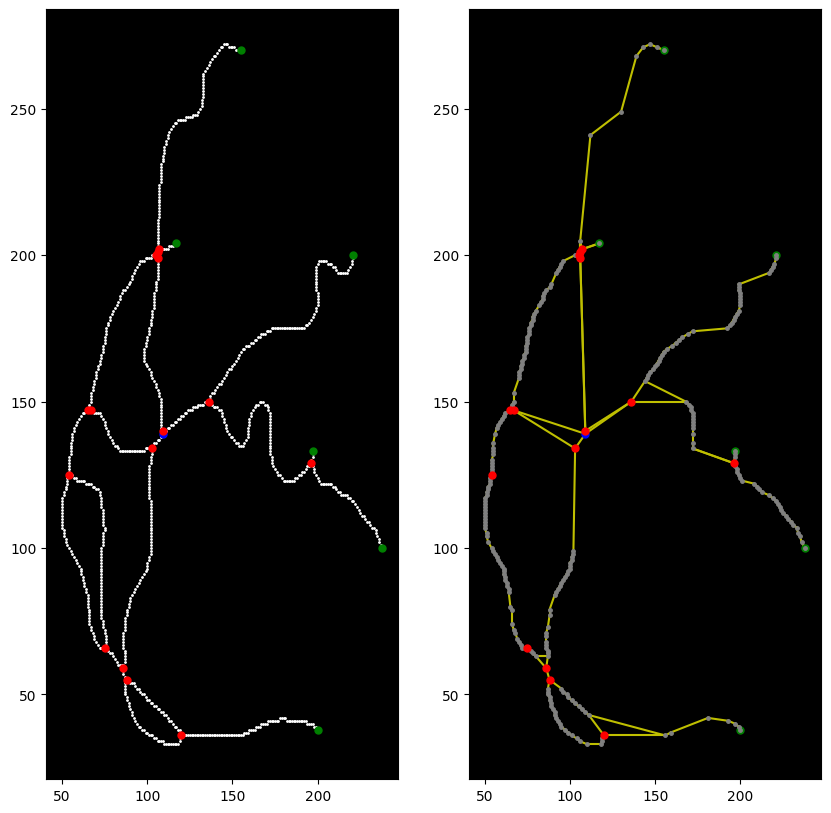

In [ ]:

# Plot original image and the resulting side by side

plt.figure(figsize=(10,10))
# ==== PLOT ORIGINAL IMAGE ====
plt.subplot(1, 2, 1)
skeleton_coords = np.argwhere(skeleton == 1)
# Plot skeleton_coords
plt.plot(skeleton_coords[:, 1], skeleton_coords[:, 0], 'wo', markersize=1)
# Plot extreme nodes
plt.plot([node[1] for node in extreme_nodes_list], 
				 [node[0] for node in extreme_nodes_list], 
				 'go',
					markersize=5)
plt.axis('on')
# Plot bifu and trifurcation
plt.plot([node[1] for node in trifurcation_nodes_list], 
				 [node[0] for node in trifurcation_nodes_list], 
				 'bo',
					markersize=5)
plt.plot([node[1] for node in bifurcation_nodes_list],
				 [node[0] for node in bifurcation_nodes_list],
				 'ro',
				 markersize=5)
# Black backgruond
plt.gca().set_facecolor('black')
# ==== PLOT ORIGINAL IMAGE ====
# ==== PLOT NEW IMAGE ====
plt.subplot(1, 2, 2)
plt.gca().set_facecolor('black')
# Plot edges
for edge in edges:
		x_values, y_values = zip(*edge)
		plt.plot(y_values, x_values, 'y-')  # 'b-' for blue lines
# Plot extreme nodes
plt.plot([node[1] for node in extreme_nodes_list], 
				 [node[0] for node in extreme_nodes_list], 
				 'go',
					markersize=5)
plt.axis('on')
# Plot ap in gray
plt.plot([node[1] for node in ap], 
				 [node[0] for node in ap], 
				 'o',
				 color='gray',
				 markersize=2.5)
# Plot bifu and trifurcation
plt.plot([node[1] for node in trifurcation_nodes_list], 
				 [node[0] for node in trifurcation_nodes_list], 
				 'bo',
					markersize=5)
plt.plot([node[1] for node in bifurcation_nodes_list],
				 [node[0] for node in bifurcation_nodes_list],
				 'ro',
				 markersize=5)
plt.show()